In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

# creating session
spark = SparkSession.builder \
    .appName("EMR_PySpark") \
    .getOrCreate()

# is it working?
print(spark.version)



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/27 10:14:09 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


3.5.2-amzn-1


In [4]:
df =spark.read.csv("s3://themovieset/movies_metadata.csv", header=True, inferSchema=True)

df.show()


+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+-----

In [5]:
#code from phase 2 proccesd on EMR

#the columns im intrested in ,my current data frame
selected_columns=df.select("id","budget","vote_average")
print(selected_columns)
#by default, Spark treats the JSON data in the column as a string,so ww will have to deal with that

DataFrame[id: string, budget: string, vote_average: string]


In [6]:
from pyspark.sql.functions import trim,col
#handleing casting with white space since its a string so it wont be null after casting

selected_columns = selected_columns.withColumn("budget", trim(col("budget")))
selected_columns = selected_columns.withColumn("vote_average", trim(col("vote_average")))

In [7]:
#for this section ill clean all columns but the json for later

##col:function is used to refer to a DataFrame column by name. It allows you to perform various operation,like casting a col
selected_columns = selected_columns.withColumn("budget", col("budget").cast("float"))
selected_columns = selected_columns.withColumn("vote_average", col("vote_average").cast("float"))
selected_columns.printSchema()

root
 |-- id: string (nullable = true)
 |-- budget: float (nullable = true)
 |-- vote_average: float (nullable = true)



In [8]:
#Check for Missing Values [null]

print("Before fixing null values:")
selected_columns.filter(
    selected_columns.id.isNull() | 
    selected_columns.budget.isNull() | 
    selected_columns.vote_average.isNull()
).show()

# Drop rows where either 'budget' or 'vote_average' is null
# Since both are critical to my analysis
selected_columns = selected_columns.dropna(subset=["budget", "vote_average"])

# Check for Missing Values [null] after fixing
print("After fixing null values:")
selected_columns.filter(
    selected_columns.id.isNull() | 
    selected_columns.budget.isNull() | 
    selected_columns.vote_average.isNull() 
).show()

Before fixing null values:


+----------+---------+------------+
|        id|   budget|vote_average|
+----------+---------+------------+
|     31357|    1.6E7|        NULL|
|      8012|  3.025E7|        NULL|
|       902|    1.8E7|        NULL|
|     11443|    1.0E7|        NULL|
|       807|    3.3E7|        NULL|
|      9536|    1.5E7|        NULL|
|      9623|    4.4E7|        NULL|
|    188588|      0.0|        NULL|
|      9283|      0.0|        NULL|
|     63076|      0.0|        NULL|
|    290157|      0.0|        NULL|
|1995-01-01|     NULL|        NULL|
|     55475|      0.0|        NULL|
|    124636|      0.0|        NULL|
|      5757|      0.0|        NULL|
|      8839|    5.0E7|        NULL|
|     17447|      0.0|        NULL|
|      9344|1500000.0|        NULL|
|     47608|      0.0|        NULL|
|     18402|      0.0|        NULL|
+----------+---------+------------+
only showing top 20 rows

After fixing null values:


+---+------+------------+
| id|budget|vote_average|
+---+------+------------+
+---+------+------------+



In [9]:
#drop duplicates rows ill measure by id, method of pyspark takes a sub set[] inside the col name 
selected_columns = selected_columns.dropDuplicates(["id"])


In [10]:
#trim whitespace 
selected_columns = selected_columns.withColumn("id", trim(col("id")))

In [11]:
#why are all budget showing 0?
# Remove rows with a budget of 0
selected_columns = selected_columns.filter(selected_columns.budget > 0)#are we removing them
# Check remaining rows after filtering
print("Remaining rows after removing zero budget:")
selected_columns.show()

Remaining rows after removing zero budget:


+------+---------+------------+
|    id|   budget|vote_average|
+------+---------+------------+
|  1572|    9.0E7|         6.9|
| 10436|    3.4E7|         7.0|
|  2088|   1.15E7|         5.7|
|  1090|    1.6E7|         6.8|
|  2294|    2.2E7|         6.4|
| 11888|    3.3E7|         5.3|
|  9583|    2.7E7|         5.6|
| 29912|4100000.0|         6.4|
|   296|    2.0E8|         5.9|
| 30923|    2.1E7|         6.1|
| 24269|8000000.0|         6.9|
|  9030|    1.2E7|         5.5|
|191714|1000000.0|         7.3|
|   451|3600000.0|         7.1|
|  9032|   3.42E7|         6.2|
| 19665|7800000.0|         4.7|
| 84329|2500000.0|         6.8|
|100402|    1.7E8|         7.6|
|187596|    1.5E7|         5.8|
| 12104|    1.2E7|         7.7|
+------+---------+------------+
only showing top 20 rows



In [12]:
from pyspark.ml.feature import VectorAssembler # ml only can take vector so 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator #evalute ur modle
#ml configration i wanna implment linear reggersion,no need for id
selected_columns = selected_columns.drop("id")
selected_columns.show()
#budget is my feature[input] my label is vote[the dependent variable]

#ml expect input as a form of vector

# Step 1: Create a feature vector for budget ,creating a new column called features
assembler = VectorAssembler(inputCols=["budget"], outputCol="features")
assembled_data = assembler.transform(selected_columns)

# Step 2: Split the data into training 80% and test 20% 
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=123)

# Step 3: Set up the linear regression model get my selected columns for predictions
lr = LinearRegression(featuresCol="features", labelCol="vote_average")

# Step 4: Train the model on the training data
lr_model = lr.fit(train_data)

# Step 5: Output the model's coefficients and intercept
#coefficients and intercept is a crucial part of understanding how the linear regression model predicts outcomes y=mx+b
# generalization based on the relationships identified across all of your training data
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Step 6: Make predictions on the test data the 20%
predictions = lr_model.transform(test_data)
predictions.select("budget", "vote_average", "prediction").show()

# Step 7: Evaluate the model using RMSE (Root Mean Squared Error) this is the standard for linear reggrssion
evaluator = RegressionEvaluator(labelCol="vote_average", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

+---------+------------+
|   budget|vote_average|
+---------+------------+
|    9.0E7|         6.9|
|    3.4E7|         7.0|
|   1.15E7|         5.7|
|    1.6E7|         6.8|
|    2.2E7|         6.4|
|    3.3E7|         5.3|
|    2.7E7|         5.6|
|4100000.0|         6.4|
|    2.0E8|         5.9|
|    2.1E7|         6.1|
|8000000.0|         6.9|
|3600000.0|         7.1|
|   3.42E7|         6.2|
|7800000.0|         4.7|
|    1.2E7|         7.7|
|6000000.0|         7.4|
| 864000.0|         6.6|
|7500000.0|         6.7|
|2500000.0|         5.7|
|    1.0E7|         5.4|
+---------+------------+
only showing top 20 rows



24/11/27 10:29:12 WARN Instrumentation: [489090ee] regParam is zero, which might cause numerical instability and overfitting.
24/11/27 10:29:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/27 10:29:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/27 10:29:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [0.0054226240704084655]
Intercept: 11417.878765934183


+------+------------+------------------+
|budget|vote_average|        prediction|
+------+------------+------------------+
|   1.0|         4.7|11417.884188558253|
|   1.0|         6.0|11417.884188558253|
|   2.0|         6.6|11417.889611182323|
|   3.0|         9.0|11417.895033806395|
|   6.0|         5.5|11417.911301678605|
|  10.0|         4.0|11417.932992174887|
|  12.0|         4.9|11417.943837423029|
|  12.0|         5.1|11417.943837423029|
|  28.0|         5.9|11418.030599408155|
|  30.0|         4.6|11418.041444656295|
|  30.0|         7.3|11418.041444656295|
|  50.0|         7.8|11418.149897137704|
|  85.0|         4.8|11418.339688980168|
| 110.0|         5.0|11418.475254581928|
| 130.0|        10.0|11418.583707063337|
| 250.0|         0.0|11419.234421951785|
| 686.0|         7.1|11421.598686046484|
| 762.0|         4.9|11422.010805475835|
|3000.0|         5.0|11434.146638145408|
|5000.0|         7.6|11444.991886286225|
+------+------------+------------------+
only showing top

Root Mean Squared Error (RMSE) on test data: 223341.3453260098


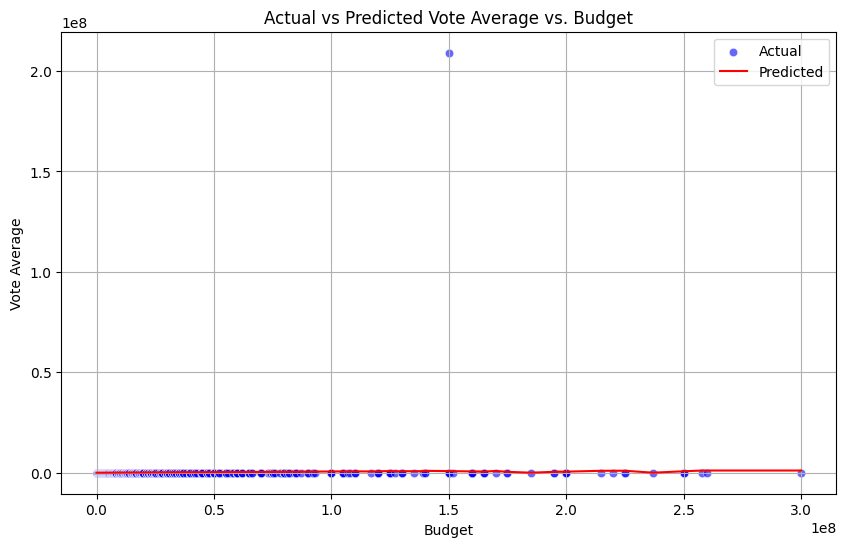

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the columns for budget, actual vote_average, and predicted vote_average and turn them to pandas data frame
x = predictions.select("budget").toPandas()
y_actual = predictions.select("vote_average").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Create a scatter plot of actual vote_average vs budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x['budget'], y=y_actual['vote_average'], label="Actual", alpha=0.6, color='blue')


sns.lineplot(x=x['budget'], y=y_pred['prediction'], label="Predicted", color='red')

# Adding labels and title
plt.title("Actual vs Predicted Vote Average vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Vote Average")

# Show the plot
plt.grid()
plt.legend()
plt.show()

In [15]:
#second file proccesing
df_Bclean=spark.read.csv("s3://themovieset/ratings.csv", header=True, inferSchema=True)
# Step 3: Show the full DataFrame schema and first few rows (optional)
df_Bclean. printSchema
df_Bclean. show(5)
# Step 4: Check the total number of records
total_records = df_Bclean.count ()
print(f"Total number of records in the dataset: {total_records}")

# Step 5: Extract a random sample
# Using sample with fraction argument to approximate 10 million rows if you know the total number of rows
fraction = 10_000_000 / total_records # Calculate the fraction needed to extract 10 million rows
df_sample = df_Bclean.sample(withReplacement=False, fraction=fraction)

# the number of records in the sampled dataset
sample_count = df_sample. count()
print(f"Number of records in the sampled dataset: {sample_count}")

# Step 6: get a random sample 10 mill
df_sample_10M = df_sample. limit (10_000_000)
# Step 7: Select the columns (movieId, userId, rating)
df_selected = df_sample.select("movieId", "userId", "rating")


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



Total number of records in the dataset: 26024289


Number of records in the sampled dataset: 10001371


In [16]:
# casting
from pyspark.sql.functions import col, trim

# Trim leading/trailing spaces and cascade the conversion from String to Integer for userId and movieId
df_casting = df_selected.withColumn("userId", trim(col("userId")).cast("int")) \
                        .withColumn("movieId", trim(col("movieId")).cast("int"))

# Display the schema after conversion
print("Schema after casting to Integer:")
df_casting.printSchema()

from pyspark.sql.functions import col, trim, sum, when  # Import col and trim functions

# Step 10: Data Cleaning
# Check for missing values in each column
missing_values = df_casting.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_casting.columns])
print("Missing Values Count per Column:")
missing_values.show()

# Drop rows with missing values
df_cleaned = df_casting.dropna()

# Step 3: Verify the cleaned DataFrame
print("Number of records after dropping missing values:")
print(df_cleaned.count())

Schema after casting to Integer:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)

Missing Values Count per Column:


+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|      0|     0|     0|
+-------+------+------+

Number of records after dropping missing values:


10001371


In [17]:
# Remove Records Where movieId is 0 or Null
df_cleaned = df_cleaned.filter((col("movieId").isNotNull()) & (col("movieId") != 0))


df_cleaned = df_cleaned.filter((col("userId").isNotNull()) & (col("userId") != 0))

#  Allow rating to be 0, but Remove Null Ratings
df_cleaned = df_cleaned.filter(col("rating").isNotNull())

# 1 Check for Duplicate Records and Remove Duplicates (Corrected column name: "movieId")
df_cleaned = df_cleaned.dropDuplicates(["userId", "movieId", "rating"])

# 1Rating Range Validation (0 to 10)
df_cleaned = df_cleaned.filter((col("rating") >= 0) & (col("rating") <= 10))

# Display the cleaned data
df_cleaned.show()

from pyspark.sql.functions import avg, count, col

# Feature 1: Count the number of ratings for each movie
movie_rating_count = df_cleaned.groupBy("movieId").agg(count("rating").alias("rating_count"))

# Feature 2: Calculate the average rating for each movie
movie_avg_rating = df_cleaned.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

# Feature 3: Count the number of unique users per movie
unique_users = df_cleaned.groupBy("movieId").agg(count("userId").alias("user_count"))

# Join the features together into a single DataFrame
features_df = movie_rating_count.join(movie_avg_rating, on="movieId").join(unique_users, on="movieId")

# Show the feature DataFrame
features_df.show(20)
from pyspark.sql.functions import count, avg

# Step 3: Aggregate data by movieId
movie_stats = df_cleaned.groupBy("movieId").agg(
    count("rating").alias("ratings_count"),  # Count the number of ratings for each movie
    avg("rating").alias("avg_rating")        # Average rating for each movie
)

# Show aggregated data and inspect before model
movie_stats.show(5)
from pyspark.sql import functions as F

# Step 4: Create a label column
# Label = 1 if movie has more than 1000 ratings, else 0
movie_stats = movie_stats.withColumn("label", F.when(movie_stats["ratings_count"] > 1000, 1).otherwise(0))

# Show data with labels
movie_stats.show(5)

# Step 5: Separate movies into "high" and "low" groups based on the label
high_movies = movie_stats.filter(movie_stats["label"] == 1)
low_movies = movie_stats.filter(movie_stats["label"] == 0)

# Step 6: Find the movie with the highest rating count in the "high" group
highest_rated_high = high_movies.orderBy(F.desc("ratings_count")).limit(1)

# Step 7: Find the movie with the lowest rating count in the "low" group
lowest_rated_low = low_movies.orderBy(F.asc("ratings_count")).limit(1)

# Show the highest and lowest movies from each group
print("Highest Rated Movie from High Group:")
highest_rated_high.show()
high_movies.show(5)

print("Lowest Rated Movie from Low Group:")
lowest_rated_low.show()


low_movies.show(5)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create the features vector
assembler = VectorAssembler(inputCols=["ratings_count", "avg_rating"], outputCol="features")
ml_data = assembler.transform(movie_stats)

# Split data into train/test sets
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)
#Display predictions
predictions.select("features", "label", "prediction").show(10)
# Evaluate the model using ROC-AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|   1967|205621|   4.5|
|   1222|205661|   5.0|
|   4643|205694|   1.0|
| 112556|205700|   4.0|
|   1991|205714|   1.5|
|   5388|205722|   4.0|
|   2763|205756|   4.0|
|    653|205783|   2.0|
|   4011|205791|   3.5|
|   2000|205829|   3.0|
|    588|205900|   2.5|
|   2852|205918|   4.0|
|    501|205938|   3.5|
|   1927|205974|   4.5|
|   2533|205991|   4.5|
|    260|206056|   4.0|
|   2533|206099|   3.0|
|  54286|206188|   5.0|
|    256|206189|   1.0|
|   2105|206215|   2.5|
+-------+------+------+
only showing top 20 rows



+-------+------------+------------------+----------+
|movieId|rating_count|        avg_rating|user_count|
+-------+------------+------------------+----------+
|   8638|        1813| 3.981246552675124|      1813|
|   8643|         513|3.2076023391812867|       513|
|   8650|          52|3.6538461538461537|        52|
|   8655|          28| 3.267857142857143|        28|
|   8705|          12|             2.375|        12|
|   8755|          29|3.8793103448275863|        29|
|   8760|          28|2.4642857142857144|        28|
|   8770|          18|2.5555555555555554|        18|
|   8774|          21|3.0476190476190474|        21|
|   8784|        4492| 3.760017809439003|      4492|
|   8811|         106|1.6556603773584906|       106|
|   8825|          16|           2.40625|        16|
|   8830|         277|1.9133574007220218|       277|
|   8834|          13|               3.0|        13|
|   8851|          33|3.6363636363636362|        33|
|   8876|           8|             3.125|     

+-------+-------------+------------------+
|movieId|ratings_count|        avg_rating|
+-------+-------------+------------------+
|   8638|         1813| 3.981246552675124|
|   8643|          513|3.2076023391812867|
|   8650|           52|3.6538461538461537|
|   8655|           28| 3.267857142857143|
|   8755|           29|3.8793103448275863|
+-------+-------------+------------------+
only showing top 5 rows



+-------+-------------+------------------+-----+
|movieId|ratings_count|        avg_rating|label|
+-------+-------------+------------------+-----+
|   3918|          567|2.9894179894179893|    0|
|   3925|          492| 3.834349593495935|    0|
|   3956|          263| 2.403041825095057|    0|
|   3963|          213|3.2582159624413145|    0|
|   3970|          107|3.4158878504672896|    0|
+-------+-------------+------------------+-----+
only showing top 5 rows

Highest Rated Movie from High Group:


+-------+-------------+------------------+-----+
|movieId|ratings_count|        avg_rating|label|
+-------+-------------+------------------+-----+
|    356|        35289|4.0599336903851055|    1|
+-------+-------------+------------------+-----+



+-------+-------------+-----------------+-----+
|movieId|ratings_count|       avg_rating|label|
+-------+-------------+-----------------+-----+
|   1088|         5196|3.254715165511932|    1|
|   1089|        13409|4.088149750167798|    1|
|   1201|         7157|  4.1290345116669|    1|
|   1206|        11825|3.984693446088795|    1|
|   1212|         3021|4.197782191327375|    1|
+-------+-------------+-----------------+-----+
only showing top 5 rows

Lowest Rated Movie from Low Group:


+-------+-------------+----------+-----+
|movieId|ratings_count|avg_rating|label|
+-------+-------------+----------+-----+
|   5565|            1|       2.0|    0|
+-------+-------------+----------+-----+



+-------+-------------+------------------+-----+
|movieId|ratings_count|        avg_rating|label|
+-------+-------------+------------------+-----+
|   3918|          567|2.9894179894179893|    0|
|   3925|          492| 3.834349593495935|    0|
|   3956|          263| 2.403041825095057|    0|
|   3963|          213|3.2582159624413145|    0|
|   3970|          107|3.4158878504672896|    0|
+-------+-------------+------------------+-----+
only showing top 5 rows



+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[10753.0,3.849111...|    1|       1.0|
|[1288.0,3.2822204...|    1|       1.0|
|[600.0,2.32833333...|    0|       0.0|
|[909.0,2.88063806...|    0|       0.0|
|[167.0,2.53892215...|    0|       0.0|
|[1023.0,3.1686217...|    1|       1.0|
|[530.0,2.40377358...|    0|       0.0|
|[12014.0,3.510862...|    1|       1.0|
|[1282.0,3.4266770...|    1|       1.0|
|[210.0,3.50714285...|    0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



ROC-AUC: 1.0


Text(0, 0.5, 'Rating Count')

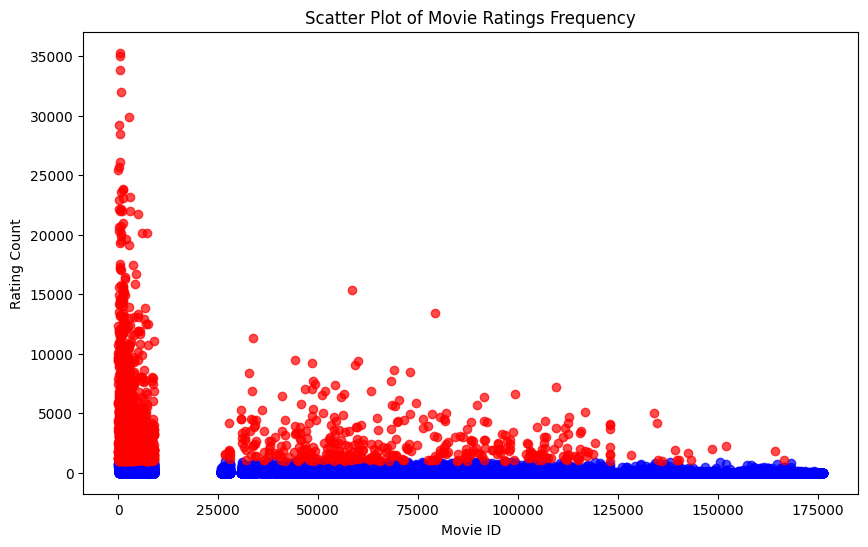

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

movie_stats = movie_stats.withColumn('label', when(movie_stats['ratings_count'] > 1000, 1).otherwise(0))


data_pandas = movie_stats.select("movieId", "ratings_count", "label").toPandas()


high_rated_movies = data_pandas[data_pandas['label'] == 1]
low_rated_movies = data_pandas[data_pandas['label'] == 0]

# Create scatter plot
plt.figure(figsize=(10,6))

# Plot low-rated movies with blue dots
plt.scatter(low_rated_movies['movieId'], low_rated_movies['ratings_count'], color='blue', label='Low Rated (<1000 ratings)', alpha=0.7)

# Plot high-rated movies with red dots
plt.scatter(high_rated_movies['movieId'], high_rated_movies['ratings_count'], color='red', label='High Rated (>1000 ratings)', alpha=0.7)

# Add title and labels
plt.title('Scatter Plot of Movie Ratings Frequency')
plt.xlabel('Movie ID')
plt.ylabel('Rating Count')